# **Advanced Lane Finding** 
***
The goal is to develop a pipeline to detect lanes in the given video sequence. Also, degree of lanes' curvature is desired. For better accuracy, a calibration step is applied to correct for camera lens distortions. 
Road lanes are then detected by applying thresholding, ROI selection, perspective transformation and a histogram approach.


In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from glob import glob
%matplotlib inline

# Camera Calibration
For calibrating a camera several reference images captured by the camera is read first. To find the best mapping from distorted image to undistorted image, number of point correspondeces are needed.
We used a chessboard to collect source points. By this, we will know how image plane points correspond to physical 3D points in world coordinates.

We will find image plane points using `cv2.findChessboardCorners` and store them in `img_pts`.

We also save camera parameters in a pickle file (`calibration_params.p`) to avoid re-computing them at every run.

In [6]:
import pickle

def calibrate_camera():
    x_points = 9
    y_points = 6
    
    objp = np.zeros((x_points * y_points, 3), np.float32)
    objp[:, :2] = np.mgrid[0:x_points, 0:y_points].T.reshape(-1, 2)

    objpoints = []  # 3D points
    imgpoints = []  # 2D points
    
    images = glob('camera_cal/calibration*.jpg')
    
    for fname in images:
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x_points, y_points), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    params = {'mtx': mtx,
              'dist': dist,
              'rvecs': rvecs,
              'tvecs': tvecs}
    return params


try:
    with open('./calibration_params.p', 'rb') as cf:
        camera_params = pickle.load(cf)
    print('Camera parameters loaded!')
except Exception as e:
    print('Invalid calibration file with (%s) exception' % e)
    camera_params = calibrate_camera()
    with open('./calibration_params.p', 'wb') as cf:
        pickle.dump(camera_params, cf)    
        print('New parameters saved in ./calibration_params.p!')

camera_matrix = camera_params['mtx']
dist_coeff = camera_params['dist']
print('Camera matrix is:')
print(camera_matrix)
print('Camera distortion coefficients are:')
print(dist_coeff)

Camera parameters loaded!
Camera matrix is:
[[  1.15396114e+03   0.00000000e+00   6.69705365e+02]
 [  0.00000000e+00   1.14802519e+03   3.85656224e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion coefficients are:
[[ -2.41019194e-01  -5.30653283e-02  -1.15809359e-03  -1.28331854e-04
    2.67011948e-02]]


# Calibration test

image dimesions: (720, 1280, 3)


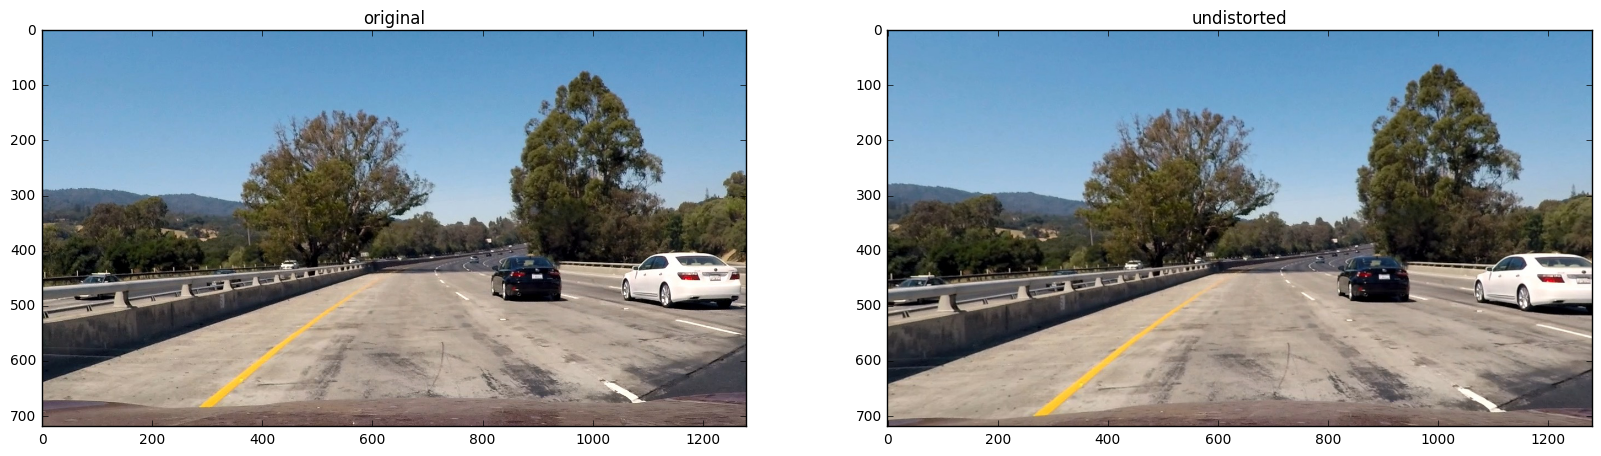

In [234]:
#reading in an image
raw_image = mpimg.imread('test_images/test1.jpg')

# distortion correction
image = cv2.undistort(raw_image, camera_matrix, dist_coeff, None, camera_matrix)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(raw_image)
plt.title("original")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(image)
plt.title("undistorted")

print('image dimesions:', image.shape)

# Creating Binary image
Binary thresholding is the most challenging step of the lane detection algorithm. To use both color and shape information of the input frame, a mix of color selection and gradient filtering is required. 

## Color selection
There are several choices for color space for color selection. To be more robust against lighting conditions and brightness, we experimentally chose **HSV** color space. In practice, we threshold and combined two color range for white and yellow pixels. The bellow thresholds are selected for color selection.

+ [0, 65, 150] < (h, s, v) < [179, 255, 255]
+ [0, 0, 205]  < (h, s, v) < [179, 255, 255]

## Sobel thresholding

Absolute and directional gradient thresholding on the gray level of RGB color space is used to further discard useless shapes of the input frame.
The input of sobel filter is first smoothed with a Gaussian kernel to reject noises. We thresholded `X` and `Y` direction with the same values. We also included magnitude of sobel output and direction of it.
The following is the thresholds range used in thresholding:

$$ 50 < Sx < 200$$
$$ 50 < Sy < 200$$
$$ 50 < \|S\| < 250$$
$$ 0.7 < \theta_S < 1.2$$
    
## Combining
We simply combined results of the above steps to create our final binary threshold. The follwoing images are some examples: 
![Alt][21]
[21]: img1.png "Steps to create binary images"

# Masking region of interest
Since not all parts of the input frame contains lines, we used a trapezoid to mask out useless regions of the input frame. The output result after applying this step is shown bellow:
![Alt][trapezoid]
[trapezoid]: img2.png "Maks region of interest"

# Perspective transform
Perspective transform is used to obtaina birds-eye view from top view of the road. This can give better estimation of the road curvature. 
Perspective transformation matrix and its inverse were obtained with `cv2.getPerspectiveTransform`, which can be used to transform to/from top-down view with the help of `cv2.warpPerspective`.
I chose the hardcode the source and destination points in the following manner:

```
OFFSET = 0
src = np.float32([(132, 703),(540, 466),(740, 466),(1147, 703)])
dst = np.float32([(132 + OFFSET, 720),(132 + OFFSET, 0),
                  (1147 - OFFSET, 0), (1147 - OFFSET, 720)])
```
Bellow, several examples of the waped frame is shown:
![Alt][perspective]
[perspective]: img3.png "Perspective transform"

# Polynomial fitting
Now that warping is competed, we should fit a polynomial to pixels that represent road lines. We fit a second order polynomila using a window searching algorithm. 

Not only fitting this polynomials for both left and right lines, we can also use the binary input to estimate the curvature of the road.
Here is the result of line fitting:
![Alt][curve]
[curve]: img4.png "Fit polynomial"

# Helper functions
**Some useful functions are defined in the next block that use OpenCV methods.
That includes:**

+ `gaussian_blur` for smoothing input image
+ `grayscale` to grayscale image
+ `abs_sobel` to compute sobel output
+ `abs_sobel_thresh` to threshold sobel absolute value
+ `dir_sobel_thresh` to threshold sobel directional value
+ `region_of_interest` for regions selection 

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions!

In [41]:
import math

imshape = (0, 0, 0)

blur_kernel_size = 3

# Define mask parameters
offset_from_left = 100
offset_from_right = 10
offset_from_bottom = 50
trapezoid_height_ratio = 0.4
trapezoid_width_ratio1 = 1
trapezoid_width_ratio2 = 0.1

# Color masking algorithm
lower_yellow = np.array([0, 65, 150])
upper_yellow = np.array([179, 255, 255])
lower_white = np.array([0, 0, 205])
upper_white = np.array([179, 255, 255])

# used for perspective transform
src = np.float32([(585, 455),(705, 455),(1130, 720),(190, 720)])
dst = np.float32([(300, 100),(1000, 100),
                  (1000, 720), (300, 720)])

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def abs_sobel(gray, orient='x', sobel_kernel=3):
    """Applies sobel filter on a gray scale image."""
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)
    sobel = np.absolute(sobel)
    return sobel

def abs_sobel_thresh(abs_sobel, thresh_low=0, thresh_high= 255):
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    output = np.zeros_like(scaled_sobel)
    output[(scaled_sobel >= thresh_low) & (scaled_sobel <= thresh_high)] = 1
    return output

def mag_sobel_thresh(sobelx, sobely, thresh_low=0, thresh_high= 255):
    # Calculate gradient magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_sobel = (255*mag_sobel/np.max(mag_sobel)).astype(np.uint8)
    output = np.zeros_like(sobelx)
    output[(mag_sobel >= thresh_low) & (mag_sobel <= thresh_high)] = 1
    return output

def dir_sobel_thresh(sobelx, sobely, thresh_low=0, thresh_high=np.pi/2):
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(sobely, sobelx)
    output =  np.zeros_like(absgraddir)
    output[(absgraddir >= thresh_low) & (absgraddir <= thresh_high)] = 1
    return output

def binary_noise_reduction(img, thresh):
    """
    Reduces noise of a binary image by applying a filter which counts neighbours with a value
    and only keeping those which are above the threshold.
    :param img: binary image (0 or 1)
    :param thresh: min number of neighbours with value
    :return:
    """
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbours < thresh] = 0
    return img

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def img_subplots(imgs, img_names=None, f_size=(12, 10), f_cols=4):
    '''Create subplots of images and return figure handle
    '''
    #assert(len(imgs) == len(img_names))
    f_rows = np.ceil(len(imgs)/f_cols).astype('int')
    fig, f_axes = plt.subplots(f_rows, f_cols, figsize=f_size)
    fig.tight_layout()
    for idx, f_ax in enumerate(f_axes.reshape(-1)):
        f_ax.axis("off")
        if idx < len(imgs):    
            img = imgs[idx]
            color_map = "gray" if len(img.shape) == 2 else None
            f_ax.imshow(img, cmap=color_map)
            if img_names !=  None:
                f_ax.set_title(img_names[idx])
    return fig

In [14]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0  # meters per pixel in x dimension

def moving_window(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
     # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return [leftx, lefty, rightx, righty]

def fit_lines(leftx, lefty, rightx, righty, img_size):

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[0]-1, img_size[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Compute radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    if not (len(lefty)==0 or len(leftx)==0 or len(righty)==0 or len(rightx)==0):
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    return [left_fitx, right_fitx, left_curverad, right_curverad]

# Main pipeline

In [43]:
def process_image(raw_image):
    global imshape
    imshape = raw_image.shape
    
    # distortion correction
    image = cv2.undistort(raw_image, camera_matrix, dist_coeff, None, camera_matrix)
    imshape = image.shape
    # Convert to gray
    gray = grayscale(image)
    
    # Convert BGR to HSV
    # HSV color space is more robust to light luminance
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # smooth image
    blur = gaussian_blur(gray, 3)

    # Threshold sobel output
    sobel_x = abs_sobel(blur, orient='x', sobel_kernel=11)
    sobel_y = abs_sobel(blur, orient='y', sobel_kernel=11)
    x_thresh = abs_sobel_thresh(sobel_x, 50, 200)
    y_thresh = abs_sobel_thresh(sobel_y, 50, 200)
    mag_thresh = mag_sobel_thresh(sobel_x, sobel_y, 50, 250)
    dir_thresh = dir_sobel_thresh(sobel_x, sobel_y, 0.7, 1.2)
    
    combined = np.zeros_like(blur)
    
    # color selection
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    p = int(np.percentile(image, 99.9) - 30)
    highlights = cv2.inRange(image, p, 255)
    combined[(mask_yellow != 0) | (mask_white != 0) | ((x_thresh == 1) &
             (y_thresh == 1)) | ((mag_thresh == 1) & (dir_thresh == 1)) | (highlights == 1)] = 255
      
    # This time we are defining a four sided polygon to mask
    height = trapezoid_height_ratio * imshape[0]
    width_large = trapezoid_width_ratio1 * imshape[1]
    width_small = trapezoid_width_ratio2 * imshape[1]

    vertices = np.array([[(offset_from_left, imshape[0] - offset_from_bottom ),
                          (width_large/2 - width_small/2, imshape[0] - height),
                          (width_large/2 + width_small/2, imshape[0] - height),
                          (width_large - offset_from_right, imshape[0] - offset_from_bottom)]], dtype=np.int32)

    # mask out undesired regions
    masked_edges = region_of_interest(combined, vertices)
    
    # Finding perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(combined, M, (1280,720), flags=cv2.INTER_LINEAR)        
        
    out_win = moving_window(warped)
    if len(out_win[0])==0 or len(out_win[1])==0 or len(out_win[2])==0 or len(out_win[3])==0:
        return raw_image
    
    
    left_fitx, right_fitx, left_curvature, right_curvature = fit_lines(*out_win, imshape)
    off_center = imshape[1] - left_fitx[-1] - right_fitx[-1]
    off_center = off_center // 2 * xm_per_pix
    left_or_right = "left" if off_center<0 else "right"
    roc_text = ("Left_ROC=%4.2fm Right_ROC=%4.2fm %4.2fm off-center to %s" 
                % (left_curvature, right_curvature, abs(off_center), left_or_right))

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, imshape[0]-1, imshape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imshape[1], imshape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.putText(result, roc_text, (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1,
                (250, 250, 250), 2)

    return result

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/straight_lines1_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/straight_lines2_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/test1_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/test2_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/test3_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/test4_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-Advanced-Lane-Lines-P4-solution/test_images/test5_out.png
saved result in /hamidb/applications/udaci

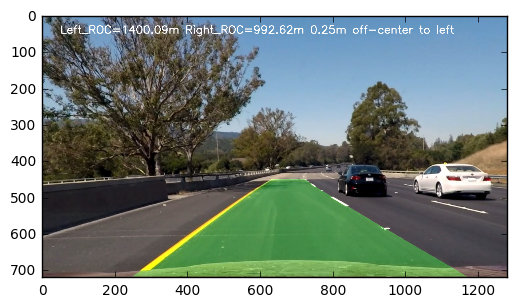

In [44]:
import os
import fnmatch

os.listdir("test_images/")

test_dir = os.getcwd() + '/test_images'
for file in os.listdir(test_dir):
    if not fnmatch.fnmatch(file, "*.jpg"):
        continue
    filename = os.path.join(test_dir, file)
    image = mpimg.imread(filename)
    result  = process_image(image)
    plt.imshow(result)
    #plt.show()
    filename = filename.split('.')[0] + "_out.png"
    print("saved result in %s" % filename)
    plt.savefig(filename, format='png')

# Sample Outputs
![Alt][output]
[output]: img5.png "Output results"

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on the provided video:

`project_video.mp4`

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [45]:
prev_right_line = []
prev_left_line = []

white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:11<00:00,  5.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 55s, sys: 40.4 s, total: 5min 35s
Wall time: 4min 12s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Reflections
## Pilepine description
The current pipeline has the following steps:
1. Color space conversion to HSV space that is more robust agains lighting conditions
2. Color thresholding to discard objects with irrelevant color 
3. Gaussian smooth filter is applied to reject noise
4. Sobel filter is used to find edges in both x and y direction
5. Sobel x and y direction thresholding is applied
6. Sobel magnitude thresholding is applied
7. Sobel directional thresholding is applied
8. Mask is applied to detect lines in region of interest
9. Perspective trasformation is applied to obtain top-view 
10. Histogram peak selection is used to find starting point for the next step
10. Moving window is used to fit polynomial to the selected pixels

## Drawbacks and sources of improvement
1. This current algorithm are prone to error when being used in different light conditions like driving at night. This is because color selection is used to discard irrelevant colors. A better color segmentation algorithm can be a possible solution. 
2. Better investigation of different color space as well as interactive threshold finding is helpful
3. Simple average filtering can be added to discard jitters
4. Better feature extraction technique can be replace with Sobel kernel
5. Change in lines' color must be addressed better fault tolerance.
